# Описание проекта

Необходимо создать и обучить модель для машинного перевода с русского языка на английский. В качестве архитектур рассмотреть RNN и трансформер. Качество перевода оценивать по метрике BLEU.

# Импорт библиотек

In [2]:
!pip install torchtext==0.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.2/73.2 kB 2.2 MB/s eta 0:00:00
  Attempting uninstall: torchtext
    Found existing installation: torchtext 0.16.0
    Uninstalling torchtext-0.16.0:
      Successfully uninstalled torchtext-0.16.0


In [3]:
import torch
import torch.nn as nn
from torch.optim import Adam, lr_scheduler
from torch.distributions import Categorical

import torchtext
from torchtext.data import Field, BucketIterator

import random
import math
import time
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import matplotlib
matplotlib.rcParams.update({'figure.figsize': (16, 12), 'font.size': 14})
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

from nltk.tokenize import WordPunctTokenizer
from nltk.translate.bleu_score import corpus_bleu

Установим случайные начальные значения для получения детерминированных результатов.

In [4]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Подготовка данных

## Загрузка датасета

В качестве датасета воспользуемся описаниями отелей и хостелов на русском и английском языках.

In [6]:
! wget https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ -O data.txt

# Thanks to YSDA NLP course team for the data

--2024-03-06 07:25:33--  https://drive.google.com/uc?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.google.com (drive.google.com)... 172.217.12.14, 2607:f8b0:4025:811::200e
Connecting to drive.google.com (drive.google.com)|172.217.12.14|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_ [following]
--2024-03-06 07:25:33--  https://drive.usercontent.google.com/download?id=1NWYqJgeG_4883LINdEjKUr6nLQPY6Yb_
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 172.217.15.225, 2607:f8b0:4025:802::2001
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|172.217.15.225|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12905334 (12M) [application/octet-stream]
Saving to: ‘data.txt’

data.txt            100%[===================>]  12.31M  26.6MB/s    in 0.5s    

2024-03-06 07:25:37 (26.6 MB/s) - ‘data.txt’ sav

## Обработка датасета

In [7]:
tokenizer_W = WordPunctTokenizer()

def tokenize_ru(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

def tokenize_en(x, tokenizer=tokenizer_W):
    return tokenizer.tokenize(x.lower())

Подготовим два типа итераторов, для RNN и для трансформера (в трансформере за батч отвечает первая размерность, а в RNN вторая)

In [8]:
SRC = Field(tokenize=tokenize_ru,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

TRG = Field(tokenize=tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True)

SRC_TR = Field(tokenize=tokenize_ru,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first=True)

TRG_TR = Field(tokenize=tokenize_en,
            init_token = '<sos>',
            eos_token = '<eos>',
            lower = True,
            batch_first=True)

dataset = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG), ('src', SRC)]
)

dataset_tr = torchtext.data.TabularDataset(
    path='data.txt',
    format='tsv',
    fields=[('trg', TRG_TR), ('src', SRC_TR)]
)

In [9]:
print(f'Количество примеров: {len(dataset.examples)}')
print(dataset.examples[0].src)
print(dataset.examples[0].trg)

Количество примеров: 50000
['отель', 'cordelia', 'расположен', 'в', 'тбилиси', ',', 'в', '3', 'минутах', 'ходьбы', 'от', 'свято', '-', 'троицкого', 'собора', '.']
['cordelia', 'hotel', 'is', 'situated', 'in', 'tbilisi', ',', 'a', '3', '-', 'minute', 'walk', 'away', 'from', 'saint', 'trinity', 'church', '.']


In [10]:
train_data, valid_data, test_data = dataset.split(split_ratio=[0.8, 0.15, 0.05])
train_data_tr, valid_data_tr, test_data_tr = dataset_tr.split(split_ratio=[0.8, 0.15, 0.05])

print(f"Количество примеров в тренировочном датасете для RNN: {len(train_data.examples)}")
print(f"Количество примеров в валидационном датасете для RNN: {len(valid_data.examples)}")
print(f"Количество примеров в тестовом датасете для RNN: {len(test_data.examples)}")
print(f"Количество примеров в тренировочном датасете для трансформера: {len(train_data_tr.examples)}")
print(f"Количество примеров в валидационном датасете для трансформера: {len(valid_data_tr.examples)}")
print(f"Количество примеров в тестовом датасете для трансформера: {len(test_data_tr.examples)}")

Количество примеров в тренировочном датасете для RNN: 40000
Количество примеров в валидационном датасете для RNN: 2500
Количество примеров в тестовом датасете для RNN: 7500
Количество примеров в тренировочном датасете для трансформера: 40000
Количество примеров в валидационном датасете для трансформера: 2500
Количество примеров в тестовом датасете для трансформера: 7500


In [11]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)
SRC_TR.build_vocab(train_data_tr, min_freq = 2)
TRG_TR.build_vocab(train_data_tr, min_freq = 2)

In [12]:
print(f"Уникальные токены в словаре источника (ru): {len(SRC.vocab)}")
print(f"Уникальные токены в целевом словаре (en): {len(TRG.vocab)}")
print(f"Уникальные токены в словаре источника (ru): {len(SRC_TR.vocab)}")
print(f"Уникальные токены в целевом словаре (en): {len(TRG_TR.vocab)}")

Уникальные токены в словаре источника (ru): 14129
Уникальные токены в целевом словаре (en): 10104
Уникальные токены в словаре источника (ru): 14129
Уникальные токены в целевом словаре (en): 10104


Пример из датасета

In [13]:
print(vars(train_data.examples[0]))

{'trg': ['the', 'hotel', 'is', 'within', '2', 'km', 'of', 'panjim', 'bus', 'stand', ',', 'dona', 'paula', 'and', 'panjim', 'church', '.'], 'src': ['отель', 'находится', 'в', '2', 'км', 'от', 'автобусной', 'остановки', 'панаджи', ',', 'поселка', 'дона', 'пола', 'и', 'церкви', 'панаджи', '.']}


Воспользуемся BucketIterator вместо стандартного итератора, поскольку он создает пакеты таким образом, что сводит к минимуму количество отступов как в исходном, так и в целевом предложениях.

In [14]:
def _len_sort_key(x):
    return len(x.src)

In [15]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

train_iterator_tr, valid_iterator_tr, test_iterator_tr = BucketIterator.splits(
    (train_data_tr, valid_data_tr, test_data_tr),
    batch_size = BATCH_SIZE,
    device = device,
    sort_key=_len_sort_key
)

# Обучение моделей

В качестве модели будем использовать модели 3 типов:
- RNN (с LSTM модулем)
- RNN (с LSTM модулем) с использованием внимания
- трансформер

In [16]:
results = {}
results['name'] = []
results['BLEU'] = []

## Функции

### Обучение моделей

In [17]:
def train_epoch(model, iterator, optimizer, criterion, clip, output_dim, train_history=None, valid_history=None, transformer=False):
    model.train()

    epoch_loss = 0
    history = []
    numb_of_token = 0

    for i, batch in enumerate(iterator):

        src = batch.src
        trg = batch.trg

        optimizer.zero_grad()

        if transformer:
            #trg = [batch, trg sent len]
            output, _ = model(src, trg[:,:-1]) #output = [batch, trg sent len - 1 , output]
            output = output.view(-1, output_dim) #output = [batch * (trg sent len - 1) , output]
            trg = trg[:,1:].reshape(-1) #trg = [batch * (trg sent len - 1)]
        else:
            #trg = [trg sent len, batch]
            output = model(src, trg) #output = [trg sent len, batch size, output]
            output = output[1:].view(-1, output_dim) #output = [(trg sent len - 1) * batch size, output]
            trg = trg[1:].view(-1) #trg = [(trg sent len - 1) * batch]

        loss = criterion(output, trg)

        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        epoch_loss += loss.item() * trg.shape[0]
        numb_of_token += trg.shape[0]

        history.append(loss.item())
        if (i+1)%10==0:
            fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 8))

            clear_output(True)
            ax[0].plot(history, label='train loss')
            ax[0].set_xlabel('Batch')
            ax[0].set_title('Train loss')
            if train_history is not None:
                ax[1].plot(train_history, label='general train history')
                ax[1].set_xlabel('Epoch')
            if valid_history is not None:
                ax[1].plot(valid_history, label='general valid history')
            plt.legend()

            plt.show()

    return epoch_loss / numb_of_token

In [18]:
def evaluate_epoch(model, iterator, criterion, output_dim, transformer=False):

    model.eval()

    epoch_loss = 0
    numb_of_token = 0

    with torch.no_grad():

        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            if transformer:
                output, _ = model(src, trg[:,:-1])
                output = output.view(-1, output_dim)
                trg = trg[:, 1:].reshape(-1)
            else:
                output = model(src, trg, 0) #turn off teacher forcing
                output = output[1:].view(-1, output_dim)
                trg = trg[1:].view(-1)

            loss = criterion(output, trg)

            epoch_loss += loss.item() * trg.shape[0]
            numb_of_token += trg.shape[0]

    return epoch_loss / numb_of_token

In [19]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [20]:
def train(model,
          train_iterator,
          valid_iterator,
          n_epochs,
          clip,
          optimizer,
          criterion,
          output_dim,
          model_name,
          transformer=False,
          scheduler=None):

    train_history = []
    valid_history = []

    best_valid_loss = float('inf')

    for epoch in range(n_epochs):

        start_time = time.time()

        train_loss = train_epoch(model,
                                 train_iterator,
                                 optimizer,
                                 criterion,
                                 clip,
                                 output_dim,
                                 train_history,
                                 valid_history,
                                 transformer=transformer)
        valid_loss = evaluate_epoch(model, valid_iterator, criterion, output_dim, transformer=transformer)

        end_time = time.time()

        epoch_mins, epoch_secs = epoch_time(start_time, end_time)

        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f'best-val-{model_name}.pt')

        train_history.append(train_loss)
        valid_history.append(valid_loss)
        print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
        print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
        print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
        if scheduler is not None:
            scheduler.step()

### Инициализация

In [21]:
def initialize_weights(model):
    if hasattr(model, 'weight') and model.weight.dim() > 1:
        nn.init.uniform_(model.weight.data, -0.08, 0.08)


def initialize_weights_transformer(model):
    if hasattr(model, 'weight') and model.weight.dim() > 1:
        nn.init.xavier_uniform_(model.weight.data)

In [22]:
def count_parameters(model):
    print(f'У модели {sum(p.numel() for p in model.parameters() if p.requires_grad)} тренируемых параметров')
    pass

### Генерация текста

In [62]:
def cut_on_eos(tokens_iter):
    for token in tokens_iter:
        if token == '<eos>':
            break
        yield token

def remove_tech_tokens(tokens_iter, tokens_to_remove=['<sos>', '<unk>', '<pad>']):
    return [x for x in tokens_iter if x not in tokens_to_remove]

def get_text(x, vocab):
     generated = remove_tech_tokens(cut_on_eos([vocab.itos[elem] for elem in list(x)]))
     return generated

def generate_source_and_trg(src, trg, SRC_vocab, TRG_vocab):
    source = get_text(src[:,0].cpu().numpy(), SRC_vocab)
    original = get_text(trg[:,0].cpu().numpy(), TRG_vocab)

    print('Источник: \n', ' '.join(source))
    print('Цель: \n', ' '.join(original))

def generate_translation_rnn(src, trg, model, SRC_vocab, TRG_vocab, max_len=150, greedy=True, T=1):
    model.eval()
    with torch.no_grad():
        output = model(src, trg, 0, mode='test', max_len=max_len, EOS=TRG.vocab.stoi[TRG.eos_token])
    if greedy:
        output = output[1:].argmax(-1)
        generated_text = [get_text(x, TRG_vocab) for x in output.detach().cpu().numpy().T]
    else:
        output = torch.softmax(output[1:] / T, dim=-1)
        distribution = Categorical(probs=output)
        generated_text = [get_text(x, TRG_vocab) for x in distribution.sample().T]
    return generated_text


def generate_translation_transformer(src_tensor, trg_field, model, device, max_len=150, greedy=True, T=1):
    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask) #enc_src = [batch, src_len, hid]

    trg_tensor = torch.zeros(len(src_tensor), max_len, dtype=torch.int).to(device)
    trg_tensor[:, 0] = torch.LongTensor([trg_field.vocab.stoi[trg_field.init_token]] * len(src_tensor))

    translations_done = torch.zeros(len(src_tensor), dtype=torch.bool).to(device)
    for i in range(1, max_len):
        trg_mask = model.make_trg_mask(trg_tensor[:,:i])
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor[:,:i], enc_src, trg_mask, src_mask)
        if greedy:
            pred_tokens = output.argmax(2)[:,-1]
        else:
            output = torch.softmax(output[:,-1] / T, dim=-1)
            distribution = Categorical(probs=output)
            pred_tokens = distribution.sample()
        trg_tensor[:,i] = pred_tokens
        translations_done = (translations_done | (pred_tokens == trg_field.vocab.stoi[trg_field.eos_token]))
        if all(translations_done):
            trg_tensor = trg_tensor[:,:i]
            break

    return [get_text(x, trg_field.vocab) for x in trg_tensor], attention

In [24]:
def calculate_bleu(src_field, trg_field, model, iterator, device, max_len=150, transformer=False, greedy=True, T=1):
    original_text = []
    generated_text = []
    model.eval()
    with torch.no_grad():

        for batch in tqdm(iterator):

            src = batch.src
            trg = batch.trg

            if transformer:
                original_text.extend([get_text(x, trg_field.vocab) for x in trg.cpu().numpy()])
                generated, _ = generate_translation_transformer(src, trg_field, model, device, max_len=max_len, greedy=greedy, T=T)
                generated_text.extend(generated)
            else:
                generated = generate_translation_rnn(src, trg, model, src_field.vocab, trg_field.vocab, greedy=greedy, T=T)
                original_text.extend([get_text(x, trg_field.vocab) for x in trg.cpu().numpy().T])
                generated_text.extend(generated)

    return corpus_bleu([[text] for text in original_text], generated_text) * 100

## RNN

В качестве основного блока воспользуемся LSTM модулем. Количество слоев возьмем равное 2, с двумя направлениями в каждом слое.

### Encoder

In [25]:
class EncoderRNN(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):

        #src = [src sent_len, batch]

        embedded = self.dropout(self.embedding(src)) #embedded = [src sent_len, batch, emb]

        _, (hidden, cell) = self.rnn(embedded)

        #outputs = [src sent len, batch, hid * n directions]
        #hidden = [n layers * n directions, batch, hid]
        #cell = [n layers * n directions, batch, hid]

        if self.bidirectional:
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim) #hidden = [n layers, n directions, batch, hid]
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim) #hidden = [n layers, batch, n directions * hid]

            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim) #cell = [n layers, n directions, batch, hid]
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim) #cell = [n layers, batch, n directions * hid]
        return hidden, cell

### Decoder

In [26]:
class DecoderRNN(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout)

        self.out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, hidden, cell):

        #input = [batch]
        #hidden = [n layers, batch, hid]
        #cell = [n layers, batch, hid]

        input = input.unsqueeze(0) #input = [1, batch]

        embedded = self.dropout(self.embedding(input)) #embedded = [1, batch size, emb dim]

        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))

        #output = [sent len, batch, hid]
        #hidden = [n layers, batch, hid]
        #cell = [n layers, batch, hid]

        prediction = self.out(output.squeeze(0)) #prediction = [batch, output dim]

        return prediction, hidden, cell

### Seq2Seq

При генерации токенов воспользуемся teacher forcing

In [27]:
class Seq2SeqRNN(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        if encoder.bidirectional:
            assert encoder.hid_dim * 2 == decoder.hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        else:
            assert encoder.hid_dim == decoder.hid_dim, \
                    "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5, mode='train', max_len=100, EOS=None):

        #src = [src len, batch]
        #trg = [trg len, batch]

        batch_size = trg.shape[1]
        trg_len = trg.shape[0] if mode == 'train' else max_len
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device) #output = [src len, batch, output]

        hidden, cell = self.encoder(src)

        #hidden = [n layers, batch, n directions * hid]
        #cell = [n layers, batch, n directions * hid]

        input = trg[0,:]
        if mode != 'train':
            translations_done = torch.LongTensor([0] * batch_size).to(device)

        for t in range(1, trg_len):

            output, hidden, cell = self.decoder(input, hidden, cell)

            #output = [batch, output dim]
            #hidden = [n layers, batch, hid]
            #cell = [n layers, batch, hid]

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(-1)

            input = trg[t] if teacher_force else top1

            if mode != 'train':
                translations_done = (translations_done | (top1 == EOS))
                if all(translations_done):
                    outputs = outputs[:t]
                    break

        return outputs #outputs = [trg len, batch, output dim]

### Инициализация

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BIDIRECTIONAL = True

enc = EncoderRNN(INPUT_DIM, ENC_EMB_DIM, HID_DIM // 2, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
dec = DecoderRNN(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_rnn = Seq2SeqRNN(enc, dec, device).to(device)

In [29]:
count_parameters(model_rnn)
model_rnn.apply(initialize_weights)

У модели 17694840 тренируемых параметров


Seq2SeqRNN(
  (encoder): EncoderRNN(
    (embedding): Embedding(14129, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderRNN(
    (embedding): Embedding(10104, 256)
    (rnn): LSTM(256, 512, num_layers=2, dropout=0.5)
    (out): Linear(in_features=512, out_features=10104, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = Adam(model_rnn.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)

### Обучение

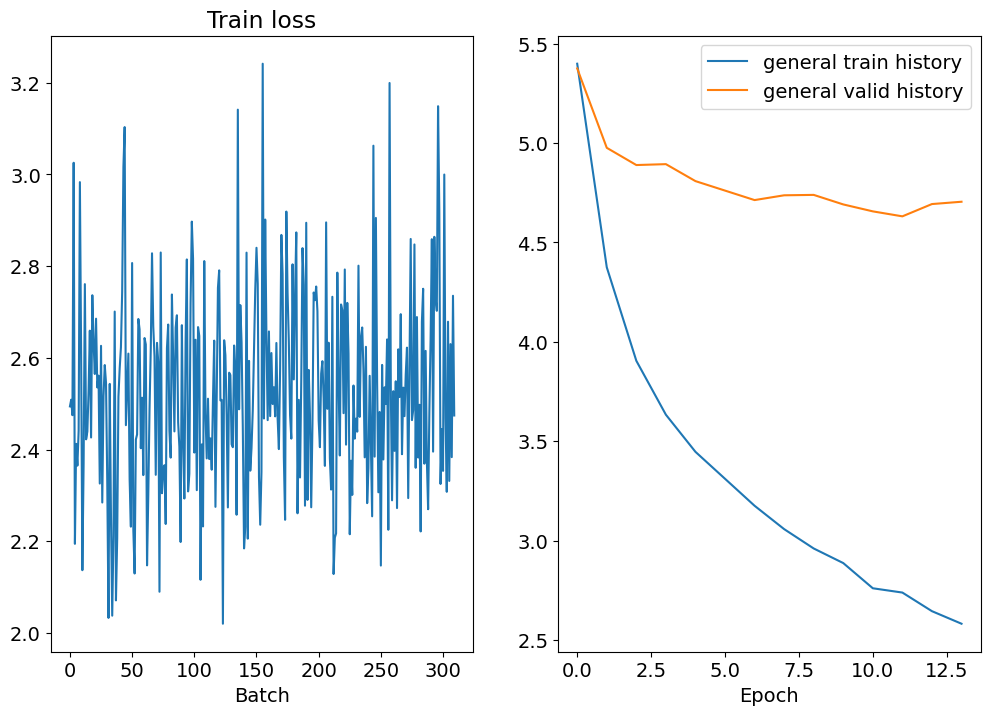

Epoch: 15 | Time: 3m 6s
	Train Loss: 2.530 | Train PPL:  12.556
	 Val. Loss: 4.651 |  Val. PPL: 104.738


In [ ]:
train(model_rnn,
      train_iterator,
      valid_iterator,
      n_epochs=15,
      clip=5,
      optimizer=optimizer,
      criterion=criterion,
      output_dim=OUTPUT_DIM,
      model_name='rnn')

### Расчет BLEU

In [48]:
model_rnn.load_state_dict(torch.load('best-val-rnn.pt'))
#model_rnn.load_state_dict(torch.load('best-val-rnn.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [95]:
BLEU = calculate_bleu(SRC, TRG, model_rnn, test_iterator, device, max_len=150)
results['name'].append('RNN (LSTM)')
results['BLEU'].append(f'{BLEU:.3f}')

print(f'BLEU для модели RNN (LSTM): {BLEU:.3f}')

  0%|          | 0/59 [00:00<?, ?it/s]

BLEU для модели RNN (LSTM): 19.519


## RNN with attention

Добавим внимание в RNN. Слой внимания будет принимать предыдущее скрытое состояние декодера
и все накопленные прямые и обратные скрытые состояния *H*
 из энкодера. Слой выведет вектор внимания *a*, размер которого -  длина исходного предложения и каждый элемент находится в диапазоне от 0 до 1, а длина всего вектора равна 1.

### Encoder

In [31]:
class EncoderRNNwithAttention(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim, n_layers, dropout, bidirectional):
        super().__init__()

        self.input_dim = input_dim
        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.n_layers = n_layers
        self.dropout = dropout
        self.bidirectional = bidirectional

        self.embedding = nn.Embedding(input_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim, hid_dim, num_layers=n_layers, dropout=dropout, bidirectional=bidirectional)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, src):

        #src = [src sent len, batch]
        embedded = self.dropout(self.embedding(src)) #embedded = [src sent len, batch, emb]

        output, (hidden, cell) = self.rnn(embedded)

        #outputs = [src sent len, batch, hid * n directions]
        #hidden = [n layers * n directions, batch, hid]
        #cell = [n layers * n directions, batch, hid]

        if self.bidirectional:
            hidden = hidden.reshape(self.n_layers, 2, -1, self.hid_dim) #hidden = [n layers, n directions, batch, hid]
            hidden = hidden.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim) #hidden = [n layers, batch, n directions * hid]

            cell = cell.reshape(self.n_layers, 2, -1, self.hid_dim)  #cell = [n layers, n directions, batch, hid]
            cell = cell.transpose(1, 2).reshape(self.n_layers, -1, 2 * self.hid_dim)  #cell = [n layers, batch, n directions * hid]

        return output, hidden, cell

### Decoder

In [32]:
class DecoderRNNwithAttention(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim, n_layers, dropout):
        super().__init__()

        self.emb_dim = emb_dim
        self.hid_dim = hid_dim
        self.output_dim = output_dim
        self.n_layers = n_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(output_dim, emb_dim)

        self.rnn = nn.LSTM(emb_dim + 2 * hid_dim, hid_dim, num_layers=n_layers, dropout=dropout)

        self.energy = nn.Linear(2 * hid_dim, hid_dim)
        self.v = nn.Linear(hid_dim, 1)

        self.out = nn.Linear(hid_dim + emb_dim + 2 * hid_dim, output_dim)

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, input, output, hidden, cell):

        #input = [batch]
        #hidden = [n layers, batch, hid]
        #cell = [n layers, batch, hid]
        #outputs = [src sent len, batch, hid]

        input = input.unsqueeze(0)

        #input = [1, batch]

        embedded = self.dropout(self.embedding(input)) #embedded = [1, batch, emb]
        hidden_for_cat = hidden[-1].repeat(output.size(0), 1, 1) #hidden_for_cat = [src sent len, batch, hid]

        H = torch.cat([output, hidden_for_cat], dim=2) #H = [src sent len, batch, 2 * hid]

        energy = torch.tanh(self.energy(H)) #energy = [src sent len, batch, hid]

        a = torch.softmax(self.v(energy), dim=0) #a = [src sent len, batch, 1]

        w_t = (a * H).sum(dim=0).unsqueeze(0) #w_t = [1, batch, 2 * hid]

        output, (hidden, cell) = self.rnn(torch.cat((embedded, w_t), dim=2), (hidden, cell))


        #output = [sent len, batch, hid]
        #hidden = [n layers, batch, hid]
        #cell = [n layers, batch, hid]

        prediction = self.out(torch.cat([embedded.squeeze(0), output.squeeze(0), w_t.squeeze(0)], dim=1)) #prediction = [batch size, output dim]

        return prediction, hidden, cell

### Seq2Seq

При генерации токенов, как и для предыдущей модели, воспользуемся teacher forcing

In [33]:
class Seq2SeqRNNwithAttention(nn.Module):
    def __init__(self, encoder, decoder, device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.device = device

        if encoder.bidirectional:
            assert encoder.hid_dim * 2 == decoder.hid_dim, \
                "Hidden dimensions of encoder and decoder must be equal!"
        else:
            assert encoder.hid_dim == decoder.hid_dim, \
                    "Hidden dimensions of encoder and decoder must be equal!"
        assert encoder.n_layers == decoder.n_layers, \
            "Encoder and decoder must have equal number of layers!"

    def forward(self, src, trg, teacher_forcing_ratio = 0.5, mode='train', max_len=100, EOS=None):

        #src = [src len, batch size]
        #trg = [trg len, batch size]

        batch_size = trg.shape[1]
        trg_len = trg.shape[0] if mode == 'train' else max_len
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(self.device)

        enc_output, hidden, cell = self.encoder(src)

        #hidden = [n layers, batch, n directions * hid]
        #cell = [n layers, batch, n directions * hid]

        input = trg[0,:]
        if mode != 'train':
            translations_done = torch.LongTensor([0] * batch_size).to(device)

        for t in range(1, trg_len):

            output, hidden, cell = self.decoder(input, enc_output, hidden, cell)

            #output = [batch, output dim]
            #hidden = [n layers, batch, hid]
            #cell = [n layers, batch, hid]

            outputs[t] = output

            teacher_force = random.random() < teacher_forcing_ratio

            top1 = output.argmax(-1)

            input = trg[t] if teacher_force else top1

            if mode != 'train':
                translations_done = (translations_done | (top1 == EOS))
                if all(translations_done):
                    outputs = outputs[:t]
                    break

        return outputs #outputs = [trg len, batch, output dim]

### Инициализация

In [34]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
ENC_EMB_DIM = 256
DEC_EMB_DIM = 256
HID_DIM = 512
N_LAYERS = 2
ENC_DROPOUT = 0.5
DEC_DROPOUT = 0.5
BIDIRECTIONAL = True

enc = EncoderRNNwithAttention(INPUT_DIM, ENC_EMB_DIM, HID_DIM // 2, N_LAYERS, ENC_DROPOUT, BIDIRECTIONAL)
dec = DecoderRNNwithAttention(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM, N_LAYERS, DEC_DROPOUT)

model_rnn_with_attention = Seq2SeqRNNwithAttention(enc, dec, device).to(device)

In [35]:
count_parameters(model_rnn_with_attention)
model_rnn_with_attention.apply(initialize_weights)

У модели 33250425 тренируемых параметров


Seq2SeqRNNwithAttention(
  (encoder): EncoderRNNwithAttention(
    (embedding): Embedding(14129, 256)
    (rnn): LSTM(256, 256, num_layers=2, dropout=0.5, bidirectional=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
  (decoder): DecoderRNNwithAttention(
    (embedding): Embedding(10104, 256)
    (rnn): LSTM(1280, 512, num_layers=2, dropout=0.5)
    (energy): Linear(in_features=1024, out_features=512, bias=True)
    (v): Linear(in_features=512, out_features=1, bias=True)
    (out): Linear(in_features=1792, out_features=10104, bias=True)
    (dropout): Dropout(p=0.5, inplace=False)
  )
)

In [ ]:
PAD_IDX = TRG.vocab.stoi['<pad>']
optimizer = Adam(model_rnn_with_attention.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss(ignore_index = PAD_IDX)
scheduler = lr_scheduler.StepLR(optimizer, step_size=8, gamma=0.1)

### Обучение

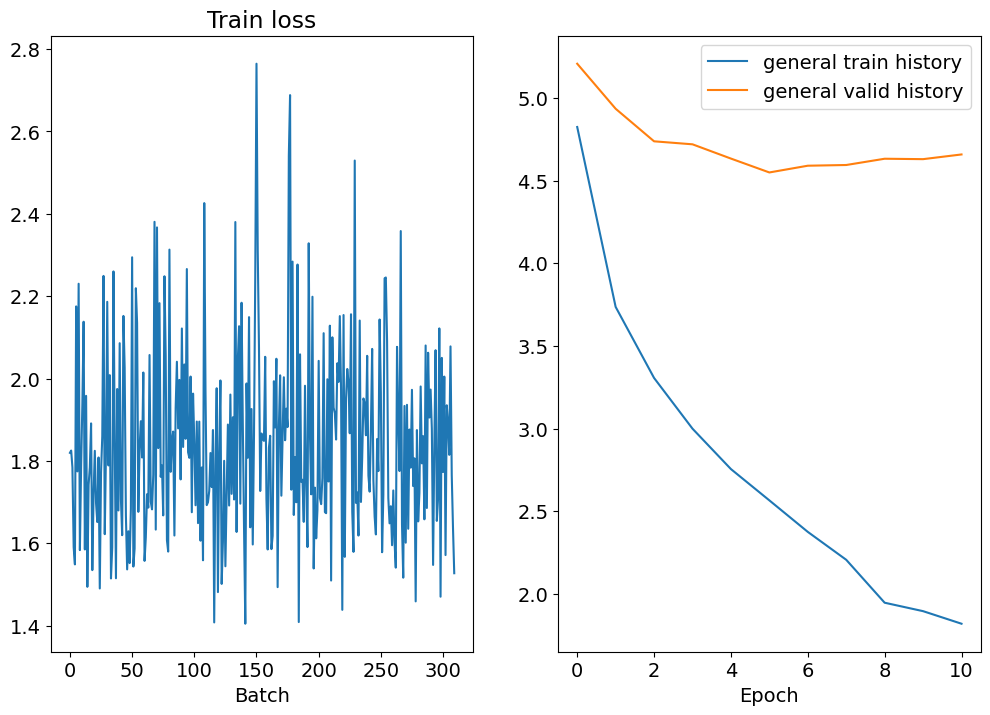

Epoch: 12 | Time: 5m 25s
	Train Loss: 1.847 | Train PPL:   6.338
	 Val. Loss: 4.671 |  Val. PPL: 106.786


In [ ]:
train(model_rnn_with_attention,
      train_iterator,
      valid_iterator,
      n_epochs=12,
      clip=5,
      optimizer=optimizer,
      criterion=criterion,
      output_dim=OUTPUT_DIM,
      model_name='rnn-with-attention',
      scheduler=scheduler)

### Расчет BLEU

In [52]:
model_rnn_with_attention.load_state_dict(torch.load('best-val-rnn-with-attention.pt'))
# model_rnn_with_attention.load_state_dict(torch.load('best-val-rnn-with-attention.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [102]:
BLEU = calculate_bleu(SRC, TRG, model_rnn_with_attention, test_iterator, device, max_len=150)
results['name'].append('RNN (LSTM) with attention')
results['BLEU'].append(f'{BLEU:.3f}')

print(f'BLEU для модели RNN (LSTM)  with attention: {BLEU:.3f}')

  0%|          | 0/59 [00:00<?, ?it/s]

BLEU для модели RNN (LSTM)  with attention: 25.409


## Transformer

### Encoder

In [36]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 dropout,
                 device):
        super().__init__()

        assert hid_dim % n_heads == 0, 'hid_dim % n_heads != 0'

        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads

        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)

        self.fc_o = nn.Linear(hid_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)

    def forward(self, query, key, value, mask = None):

        batch_size = query.shape[0]

        #Q = [batch, query len, hid]
        #K = [batch, key len, hid]
        #V = [batch, value len, hid]

        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)

        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) #Q = [batch, n_heads, query len, head]
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) #K = [batch, n_heads, key len, head]
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3) #V = [batch, n_heads, value len, head]

        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale #energy = [batch, n_heads, query len, key len]

        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)

        attention = torch.softmax(energy, dim = -1) #attention = [batch, n_heads, query len, key len]

        x = torch.matmul(self.dropout(attention), V) #x = [batch, n_heads, query len, head]

        x = x.permute(0, 2, 1, 3).contiguous()
        x = x.view(batch_size, -1, self.hid_dim) #x = [batch, query len, hid]

        x = self.fc_o(x)

        return x, attention

In [37]:
class PositionwiseFeedForwardLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 pf_dim,
                 dropout):
        super().__init__()

        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):

        #x = [batch, seq_len, hid_dim]

        x = self.dropout(self.fc_1(x)) #x = [batch, seq_len, pf_dim]
        x = self.fc_2(x) #x = [batch, seq_len, hid_dim]

        return x

In [38]:
class EncoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedForwardLayer(hid_dim, pf_dim, dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, src, src_mask):

        #src = [batch, src len, hid]
        #src_mask = [batch, 1, 1, src_len]

        _src, _ = self.self_attention(src, src, src, src_mask)
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        _src = self.positionwise_feedforward(src)
        src = self.ff_layer_norm(src + self.dropout(_src)) #src = [batch, src len, hid]

        return src

In [39]:
class EncoderTransformer(nn.Module):
    def __init__(self,
                 input_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=150):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, src, src_mask):

        #src = [batch, src len]
        #src_mask = [batch, 1, 1, src_len]

        batch_size = src.shape[0]
        src_len = src.shape[1]

        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) #pos = [batch, src_len]

        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos)) #src = [batch, src_len, hid]

        for layer in self.layers:
            src = layer(src, src_mask)

        return src

### Decoder

In [40]:
class DecoderLayer(nn.Module):
    def __init__(self,
                 hid_dim,
                 n_heads,
                 pf_dim,
                 dropout,
                 device):
        super().__init__()

        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedForwardLayer(hid_dim, pf_dim, dropout)

        self.dropout = nn.Dropout(dropout)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #trg = [batch, trg_len, hid]
        #enc_src = [batch, src_len, hid]
        #trg_mask = [batch, 1, trg_len, trg_len]
        #src_mask = [batch, 1, 1, src_len]

        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)

        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))

        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)

        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))

        _trg = self.positionwise_feedforward(trg)

        trg = self.ff_layer_norm(trg + self.dropout(_trg))

        return trg, attention

In [41]:
class DecoderTransformer(nn.Module):
    def __init__(self,
                 output_dim,
                 hid_dim,
                 n_layers,
                 n_heads,
                 pf_dim,
                 dropout,
                 device,
                 max_length=150):
        super().__init__()

        self.device = device

        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)

        self.layers = nn.ModuleList([DecoderLayer(hid_dim, n_heads, pf_dim, dropout, device) for _ in range(n_layers)])

        self.fc_out = nn.Linear(hid_dim, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)

    def forward(self, trg, enc_src, trg_mask, src_mask):

        #src = [batch, src len]
        #src_mask = [batch, 1, 1, src_len]

        batch_size = trg.shape[0]
        trg_len = trg.shape[1]

        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device) #pos = [batch, src_len]

        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos)) #src = [batch, src_len, hid]

        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)

        #trg = [batch, trg_len, hid]
        #attention = [batch, n_heads, trg_len, src_len]

        output = self.fc_out(trg)

        return output, attention

### Seq2Seq

In [42]:
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 encoder,
                 decoder,
                 src_pad_idx,
                 trg_pad_idx,
                 device):
        super().__init__()

        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device

    def make_src_mask(self, src):

        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2) # src_mask = [batch, 1, 1, src_len]

        return src_mask

    def make_trg_mask(self, trg):

        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2) # src_mask = [batch, 1, 1, src_len]

        trg_len = trg.shape[1]

        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device=self.device)).bool()

        trg_mask = trg_pad_mask & trg_sub_mask #trg_mask = [batch, 1, trg_len, trg_len]

        return trg_mask

    def forward(self, src, trg):

        src_mask = self.make_src_mask(src) # src_mask = [batch, 1, 1, src_len]
        trg_mask = self.make_trg_mask(trg) #trg_mask = [batch, 1, trg_len, trg_len]
        enc_src = self.encoder(src, src_mask) #enc_src = [batch, src_len, hid]
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        #output = [batch, trg_len, hid]
        #output = [batch, n_heads, trg_len, head]

        return output, attention

### Иницилизация

In [43]:
INPUT_DIM = len(SRC_TR.vocab)
OUTPUT_DIM = len(TRG_TR.vocab)
SRC_PAD_IDX = SRC_TR.vocab.stoi[SRC_TR.pad_token]
TRG_PAD_IDX = TRG_TR.vocab.stoi[TRG_TR.pad_token]
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = EncoderTransformer(INPUT_DIM,
                         HID_DIM,
                         ENC_LAYERS,
                         ENC_HEADS,
                         ENC_PF_DIM,
                         ENC_DROPOUT,
                         device)

dec = DecoderTransformer(OUTPUT_DIM,
                         HID_DIM,
                         DEC_LAYERS,
                         DEC_HEADS,
                         DEC_PF_DIM,
                         DEC_DROPOUT,
                         device)

model_transformer = Seq2SeqTransformer(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [44]:
count_parameters(model_transformer)
model_transformer.apply(initialize_weights_transformer)

У модели 12830840 тренируемых параметров


Seq2SeqTransformer(
  (encoder): EncoderTransformer(
    (tok_embedding): Embedding(14129, 256)
    (pos_embedding): Embedding(150, 256)
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedForwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, i

In [84]:
LEARNING_RATE = 5e-4

optimizer = torch.optim.Adam(model_transformer.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.2)

### Обучение

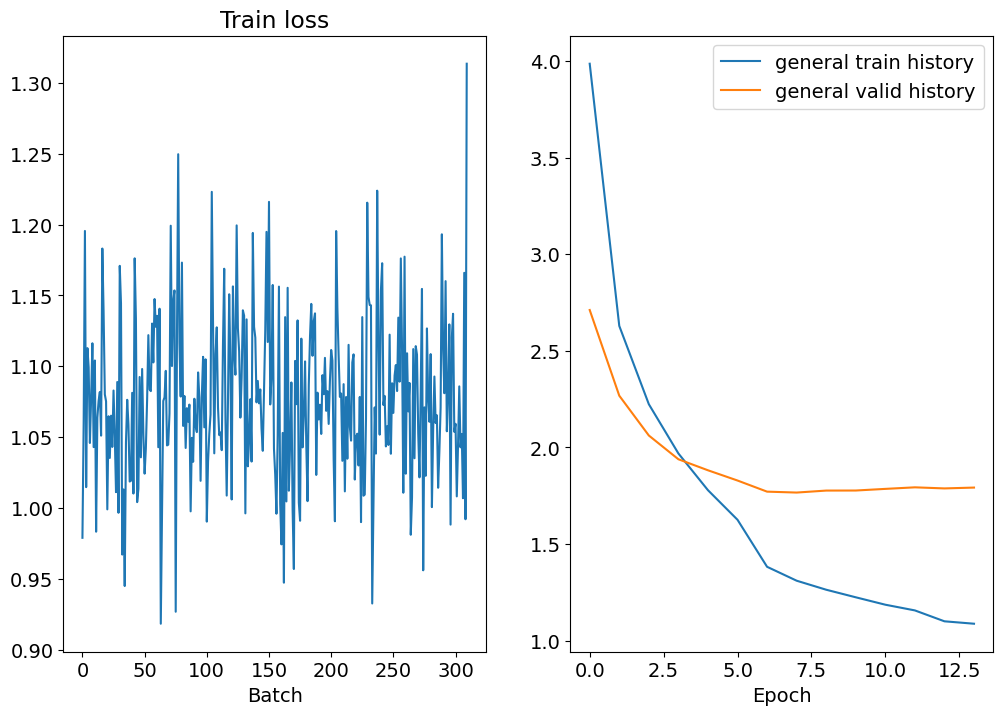

Epoch: 15 | Time: 0m 48s
	Train Loss: 1.079 | Train PPL:   2.941
	 Val. Loss: 1.794 |  Val. PPL:   6.014


In [85]:
train(model_transformer,
      train_iterator_tr,
      valid_iterator_tr,
      n_epochs=15,
      clip=1,
      optimizer=optimizer,
      criterion=criterion,
      output_dim=OUTPUT_DIM,
      model_name='transformer',
      transformer=True,
      scheduler=scheduler)

### Расчет BLEU

In [46]:
model_transformer.load_state_dict(torch.load('best-val-transformer.pt'))
#model_transformer.load_state_dict(torch.load('best-val-transformer.pt', map_location=torch.device('cpu')))

<All keys matched successfully>

In [104]:
BLEU = calculate_bleu(SRC_TR, TRG_TR, model_transformer, test_iterator_tr, device, max_len=150, transformer=True)
results['name'].append('transformer')
results['BLEU'].append(f'{BLEU:.3f}')

print(f'BLEU для модели transformer: {BLEU:.3f}')

  0%|          | 0/59 [00:00<?, ?it/s]

BLEU для модели transformer: 29.368


# Выбор модели

Сравним значения метрик для обученных моделей.

In [105]:
pd.DataFrame(results).set_index('name')

,BLEU
name,
RNN (LSTM),19.519
RNN (LSTM) with attention,25.409
transformer,29.368


Лучшее значение метрики BLEU получили для архитектуры трансформер.

Посмотрим, можно ли улучшить метрику, если использовать сэмплирование, вместо жадного поиска.

In [106]:
for t in [0.01, 0.05, 0.1, 0.5, 1]:
    BLEU = calculate_bleu(SRC_TR, TRG_TR, model_transformer, test_iterator_tr, device, max_len=150, transformer=True, greedy=False, T=t)
    print(f'Temperature={t:.2f}, BLEU={BLEU:.3f}' )

  0%|          | 0/59 [00:00<?, ?it/s]

Temperature=0.01, BLEU=29.363


  0%|          | 0/59 [00:00<?, ?it/s]

Temperature=0.05, BLEU=29.407


  0%|          | 0/59 [00:00<?, ?it/s]

Temperature=0.10, BLEU=29.392


  0%|          | 0/59 [00:00<?, ?it/s]

Temperature=0.50, BLEU=27.880


  0%|          | 0/59 [00:00<?, ?it/s]

Temperature=1.00, BLEU=22.040


Как видно, если использовать сэмплирование и подобрать температуру, можно незначительно улучшить качество.

# Сравнение генерации текста

Помимо сравнения по метрике BLEU, стоит также оценить результат перевода глазами. Добавим к жадному поиску сэмплирование с температурой равной 1 (при более низкой температуре на небольшой выборке разницы между сэмплирование и жадным поиском возможно и не будет).

In [53]:
batch = next(iter(test_iterator))

In [63]:
for idx in range(10):
    src = batch.src[:, idx:idx+1]
    trg = batch.trg[:, idx:idx+1]

    print(f'----{idx}----')
    generate_source_and_trg(src, trg, SRC.vocab, TRG.vocab)
    print('Жадно сгенерированный, RNN: \n', ' '.join(generate_translation_rnn(src, trg, model_rnn, SRC.vocab, TRG.vocab, greedy=True)[0]))
    print('Сгенерированный сэмплированием, RNN (температура = 1): \n',
          ' '.join(generate_translation_rnn(src, trg, model_rnn, SRC.vocab, TRG.vocab, greedy=False, T=1)[0]))
    print('Жадно сгенерированный, RNN with attention: \n',
          ' '.join(generate_translation_rnn(src, trg, model_rnn_with_attention, SRC.vocab, TRG.vocab, greedy=True)[0]))
    print('Сгенерированный сэмплированием, RNN with attention (температура = 1): \n',
          ' '.join(generate_translation_rnn(src, trg, model_rnn_with_attention, SRC.vocab, TRG.vocab, greedy=False, T=1)[0]))
    greedy_text, _ = generate_translation_transformer(src.T, TRG_TR, model_transformer, device, max_len=150, greedy=True)
    print('Жадно сгенерированный, transformer: \n', ' '.join(greedy_text[0]))
    not_greedy_text, _ = generate_translation_transformer(src.T, TRG_TR, model_transformer, device, max_len=150, greedy=False, T=1)
    print('Сгенерированный сэмплированием, transformer (температура = 1): \n', ' '.join(not_greedy_text[0]))

----0----
Источник: 
 стойка регистрации открыта круглосуточно .
Цель: 
 there is a 24 - hour front desk at the property .
Жадно сгенерированный, RNN: 
 you will find a 24 - hour front desk .
Сгенерированный сэмплированием, RNN (температура = 1): 
 you will find a 24 - hour front desk and
Жадно сгенерированный, RNN with attention: 
 there is a 24 - hour front desk at the property .
Сгенерированный сэмплированием, RNN with attention (температура = 1): 
 you is a 24 - hour front desk and gasthof property hour
Жадно сгенерированный, transformer: 
 there is a 24 - hour front desk at the property .
Сгенерированный сэмплированием, transformer (температура = 1): 
 there is a 24 - hour front desk on site .
----1----
Источник: 
 стойка регистрации работает круглосуточно .
Цель: 
 you will find a 24 - hour front desk at the property .
Жадно сгенерированный, RNN: 
 you will find a 24 - hour front desk .
Сгенерированный сэмплированием, RNN (температура = 1): 
 at is find a 24 ’ hour front desk .
Ж

По данным примерам перевод модели `transformer` наиболее близок к целевому.

# Вывод

В результате работы были обучены модели трех архитектур (RNN, RNN with attention, transformer). Для каждой модели была рассчитана метрика BLEU на тестовой выборке. Лучшее значение у модели `transformer`. Также у этой модели перевод оказался наиболее близким к целевому для 10 примеров из тестового датасета. Незначительно улучшить значение метрики удалось, используя сэмплирование вместо жадного поиска при генерации перевода.